In [50]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [51]:
# coding=utf-8

# Author: Alceu Britto
#

!pip install deslib

import lib_analise
import matplotlib.pyplot as plt
import matplotlib as pl
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network  import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from deslib.util.datasets import make_P2
from sklearn.model_selection import GridSearchCV
from sklearn import manifold, datasets
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits, load_breast_cancer, load_iris
import itertools
import pandas as pd
import seaborn as sns
import urllib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Defaulting to user installation because normal site-packages is not writeable


In [52]:
#variaveis globais
import lib_analise 
info_modelo = lib_analise.get_info_modelo()  # para garantir que a fun√ß√£o est√° carregada da
nome_dataset = info_modelo['nome_dataset']
arq_dataset_csv = info_modelo['parametros']['arq_dataset_csv']
arq_dataset_pkl = info_modelo['parametros']['arq_dataset_pkl']
print(nome_dataset)

svm


In [53]:
# Plotting the confusion matrix
def plot_confusion_matrix(ax, cm, title=None):

    df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
    sns.heatmap(df_cm, annot=True)
    ax.set_title('Confusion Matrix --> ' + title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return ax

In [54]:
# Plotting-related functions
def make_grid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


In [55]:
# Plotting the dataset

def plot_dataset(X, y, ax=None, title=None, **params):

    X_t=pd.DataFrame(X)
    y=pd.DataFrame(y)
    XY=pd.concat([X_t,y], axis=1)
    XY.columns = ['x', 'y', 'digit']

    customPalette=sns.hls_palette(10, l=.7, s=1)

    ax.set_xlim(XY['x'].min()*0.98,XY['x'].max()*1.02)
    ax.set_ylim(XY['y'].min()*0.98,XY['y'].max()*1.02)

    for i in range(0,10):
        k=0
        for l, row in XY.loc[XY['digit']==i,:].iterrows():
            if k==0:
                ax.plot(row['x'], row['y'], '.', color=customPalette[i], label=int(row['digit']))
                ax.legend(numpoints=1, markerscale=3, loc='upper right', bbox_to_anchor=(1.2, 1.0))
                k += 1
            ax.annotate(int(row['digit']), (row['x'], row['y']), horizontalalignment='center', verticalalignment='center', size=10, color=customPalette[i])
            ax.set_title(title, fontsize=15)

    return ax

In [56]:
# Plotting the Classifier Decision

def plot_classifier_decision(ax, clf, X, X_embedded, mode='line', **params):

# create meshgrid
    resolution = 200 # 100x100 background pixels
    y_predicted = clf.predict(X);
    X2d_xmin, X2d_xmax = np.min(X_embedded[:,0]), np.max(X_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_embedded[:,1]), np.max(X_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_embedded, y_predicted)
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

#plot
    ax.contourf(xx, yy, voronoiBackground, levels=10, cmap="RdBu_r")
    plot_dataset(X_embedded, y_predicted, ax, 'teste', **params)

    return ax


In [57]:
# Loading datasets
rng = np.random.RandomState(123)

datasets = lib_analise.get_dataset_analise(analise_ganho_de_informacao=True)
X_train = datasets['X_train']
X_test = datasets['X_test']
X_val = datasets['X_val']

y_train = datasets['y_train']
y_test = datasets['y_test']
y_val = datasets['y_val']
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(32259, 2)
(24194, 2)
(24195, 2)


In [58]:
# Define single classifiers (monolithic Classifiers)

dt =  DecisionTreeClassifier(criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=3)
knnw = KNeighborsClassifier(n_neighbors=3, weights='distance')
mlp = MLPClassifier(solver='lbfgs', early_stopping=True, hidden_layer_sizes=(32), activation='logistic', batch_size=100, max_iter=10000, learning_rate_init=0.001, momentum=0.8, random_state=46)
nb = GaussianNB(var_smoothing=1e-09)

# parameters for SVM
parameters = [
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'kernel': ['poly']},
  {'C': [0.1, 0.5, 1, 10, 100, 500, 1000], 'gamma': [0.1, 0.001, 0.0001, 0.00001], 'kernel': ['rbf']},
]
svm = SVC(gamma='scale', probability=True, random_state=42)
svm = GridSearchCV(svm, parameters, scoring = 'accuracy', cv=10)

# Define ensembles (homogeneous and heterogeneous)
rf = RandomForestClassifier(n_estimators=100, random_state=0)
cb = VotingClassifier(estimators=[('DecisionTree', dt), ('NaiveBayes', nb), ('knn', knn)], voting='soft')
bg = BaggingClassifier(estimator=knn, n_estimators=100, random_state=0)
ada = AdaBoostClassifier(n_estimators=100, random_state=0)
xgboost = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

#titles = ['DecisionTree', 'KNN', 'KNN_W', 'NaiveBayes', 'MLP', 'SVM', 'RF', 'DT+NB+KNN', 'Bag', 'Ada', 'XGBoost']
#methods = [dt, knn, knnw, nb, mlp, svm, rf, cb, bg, ada, xgboost]

titles = ['DecisionTree', 'RF', 'KNN', 'NaiveBayes', 'MLP', 'XGBoost','ADA','DT+NB+KNN']
methods = [dt, rf, knn, nb, mlp, xgboost,ada,cb]





In [59]:
# Fit the classifiers
scores = []
for method, name in zip(methods, titles):
    method.fit(X_train, y_train)
    scores.append(method.score(X_test, y_test))
    print("Classification accuracy {} = {}"
          .format(name, method.score(X_test, y_test)))


Classification accuracy DecisionTree = 0.9930561296189138
Classification accuracy RF = 0.9932214598660825
Classification accuracy KNN = 0.9922294783830702
Classification accuracy NaiveBayes = 0.8434322559312226
Classification accuracy MLP = 0.56617343142928
Classification accuracy RF = 0.9932214598660825
Classification accuracy KNN = 0.9922294783830702
Classification accuracy NaiveBayes = 0.8434322559312226
Classification accuracy MLP = 0.56617343142928
Classification accuracy XGBoost = 0.9900388526080847
Classification accuracy XGBoost = 0.9900388526080847
Classification accuracy ADA = 0.989873522360916
Classification accuracy DT+NB+KNN = 0.9926841365627842
Classification accuracy ADA = 0.989873522360916
Classification accuracy DT+NB+KNN = 0.9926841365627842


In [60]:
# Gera√ß√£o de Dataset com M√©tricas de Avalia√ß√£o dos Modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd
import os
from datetime import datetime

print("üìä Gerando dataset com m√©tricas de avalia√ß√£o dos modelos...")

# Lista para armazenar as m√©tricas
metrics_data = []

# Iterar por todos os modelos treinados
for clf, title in zip(methods, titles):
    print(f"üîç Avaliando modelo: {title}")
    
    try:
        # Fazer predi√ß√µes no conjunto de teste
        y_pred = clf.predict(X_test)
        
        # Calcular m√©tricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Adicionar dados √† lista
        metrics_data.append({
            'modelo': title,
            'acuracia': accuracy,
            'precisao': precision,
            'recall': recall,
            'f1_score': f1,
            'dataset': nome_dataset,
            'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
        
        print(f"   ‚úÖ {title}: Acur√°cia={accuracy:.4f}, Precis√£o={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        
    except Exception as e:
        print(f"   ‚ùå Erro ao avaliar {title}: {e}")
        
        # Adicionar dados com erro
        metrics_data.append({
            'modelo': title,
            'acuracia': None,
            'precisao': None,
            'recall': None,
            'f1_score': None,
            'dataset': nome_dataset,
            'data_avaliacao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })

# Criar DataFrame com as m√©tricas
metrics_df = pd.DataFrame(metrics_data)

# Exibir o dataset
print(f"\nüìã DATASET DE M√âTRICAS GERADO:")
print("=" * 80)
print(metrics_df.to_string(index=False, float_format='%.4f'))

# Estat√≠sticas resumidas
print(f"\nüìà ESTAT√çSTICAS RESUMIDAS:")
print("=" * 50)
if len(metrics_df[metrics_df['acuracia'].notna()]) > 0:
    valid_metrics = metrics_df[metrics_df['acuracia'].notna()]
    
    print(f"N√∫mero de modelos avaliados: {len(valid_metrics)}")
    print(f"Melhor acur√°cia: {valid_metrics['acuracia'].max():.4f} ({valid_metrics.loc[valid_metrics['acuracia'].idxmax(), 'modelo']})")
    print(f"Melhor precis√£o: {valid_metrics['precisao'].max():.4f} ({valid_metrics.loc[valid_metrics['precisao'].idxmax(), 'modelo']})")
    print(f"Melhor recall: {valid_metrics['recall'].max():.4f} ({valid_metrics.loc[valid_metrics['recall'].idxmax(), 'modelo']})")
    print(f"Melhor F1-Score: {valid_metrics['f1_score'].max():.4f} ({valid_metrics.loc[valid_metrics['f1_score'].idxmax(), 'modelo']})")
    
    print(f"\nM√©dia das m√©tricas:")
    print(f"  Acur√°cia m√©dia: {valid_metrics['acuracia'].mean():.4f}")
    print(f"  Precis√£o m√©dia: {valid_metrics['precisao'].mean():.4f}")
    print(f"  Recall m√©dio: {valid_metrics['recall'].mean():.4f}")
    print(f"  F1-Score m√©dio: {valid_metrics['f1_score'].mean():.4f}")

# Salvar o dataset em arquivo CSV
dataset_dir = os.path.join('..', 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
metrics_filename = f'metricas_modelos_{nome_dataset}_{timestamp}.csv'
metrics_filepath = os.path.join(dataset_dir, metrics_filename)

try:
    metrics_df.to_csv(metrics_filepath, index=False, encoding='utf-8')
    print(f"\nüíæ Dataset salvo em: {metrics_filepath}")
    
    # Verificar o tamanho do arquivo
    file_size = os.path.getsize(metrics_filepath)
    print(f"üìÅ Tamanho do arquivo: {file_size} bytes ({file_size/1024:.2f} KB)")
    
except Exception as e:
    print(f"\n‚ùå Erro ao salvar dataset: {e}")

# Ranking dos modelos por acur√°cia
print(f"\nüèÜ RANKING DOS MODELOS (por acur√°cia):")
print("=" * 60)
valid_models = metrics_df[metrics_df['acuracia'].notna()].copy()
if len(valid_models) > 0:
    valid_models_sorted = valid_models.sort_values('acuracia', ascending=False).reset_index(drop=True)
    
    for i, row in valid_models_sorted.iterrows():
        medal = "ü•á" if i == 0 else "ü•à" if i == 1 else "ü•â" if i == 2 else f"{i+1:2d}."
        print(f"{medal} {row['modelo']:15s}: {row['acuracia']:6.4f} (Precis√£o: {row['precisao']:6.4f}, Recall: {row['recall']:6.4f}, F1: {row['f1_score']:6.4f})")

print(f"\nüéâ An√°lise completa! Dataset gerado com {len(metrics_df)} modelos.")

# Disponibilizar o DataFrame para uso posterior
print(f"\nüí° O DataFrame 'metrics_df' est√° dispon√≠vel para an√°lises adicionais.")

üìä Gerando dataset com m√©tricas de avalia√ß√£o dos modelos...
üîç Avaliando modelo: DecisionTree
   ‚úÖ DecisionTree: Acur√°cia=0.9931, Precis√£o=0.9931, Recall=0.9931, F1=0.9931
üîç Avaliando modelo: RF
   ‚úÖ RF: Acur√°cia=0.9932, Precis√£o=0.9933, Recall=0.9932, F1=0.9932
üîç Avaliando modelo: KNN
   ‚úÖ KNN: Acur√°cia=0.9922, Precis√£o=0.9923, Recall=0.9922, F1=0.9922
üîç Avaliando modelo: NaiveBayes
   ‚úÖ NaiveBayes: Acur√°cia=0.8434, Precis√£o=0.8454, Recall=0.8434, F1=0.8439
üîç Avaliando modelo: MLP
   ‚úÖ MLP: Acur√°cia=0.5662, Precis√£o=0.3206, Recall=0.5662, F1=0.4093
üîç Avaliando modelo: XGBoost
   ‚úÖ XGBoost: Acur√°cia=0.9900, Precis√£o=0.9901, Recall=0.9900, F1=0.9900
üîç Avaliando modelo: ADA
   ‚úÖ ADA: Acur√°cia=0.9899, Precis√£o=0.9899, Recall=0.9899, F1=0.9899
üîç Avaliando modelo: DT+NB+KNN
   ‚úÖ MLP: Acur√°cia=0.5662, Precis√£o=0.3206, Recall=0.5662, F1=0.4093
üîç Avaliando modelo: XGBoost
   ‚úÖ XGBoost: Acur√°cia=0.9900, Precis√£o=0.9901, Recall=0

üéØ Gerando Matrizes de Confus√£o para todos os modelos...
üìä Processando modelo 1/8: DecisionTree
   ‚úÖ DecisionTree: Acur√°cia = 99.31%
üìä Processando modelo 2/8: RF
   ‚úÖ DecisionTree: Acur√°cia = 99.31%
üìä Processando modelo 2/8: RF
   ‚úÖ RF: Acur√°cia = 99.32%
üìä Processando modelo 3/8: KNN
   ‚úÖ RF: Acur√°cia = 99.32%
üìä Processando modelo 3/8: KNN
   ‚úÖ KNN: Acur√°cia = 99.22%
üìä Processando modelo 4/8: NaiveBayes
   ‚úÖ NaiveBayes: Acur√°cia = 84.34%
üìä Processando modelo 5/8: MLP
   ‚úÖ KNN: Acur√°cia = 99.22%
üìä Processando modelo 4/8: NaiveBayes
   ‚úÖ NaiveBayes: Acur√°cia = 84.34%
üìä Processando modelo 5/8: MLP
   ‚úÖ MLP: Acur√°cia = 56.62%
üìä Processando modelo 6/8: XGBoost
   ‚úÖ MLP: Acur√°cia = 56.62%
üìä Processando modelo 6/8: XGBoost
   ‚úÖ XGBoost: Acur√°cia = 99.00%
üìä Processando modelo 7/8: ADA
   ‚úÖ XGBoost: Acur√°cia = 99.00%
üìä Processando modelo 7/8: ADA
   ‚úÖ ADA: Acur√°cia = 98.99%
üìä Processando modelo 8/8: DT+NB+KNN
  

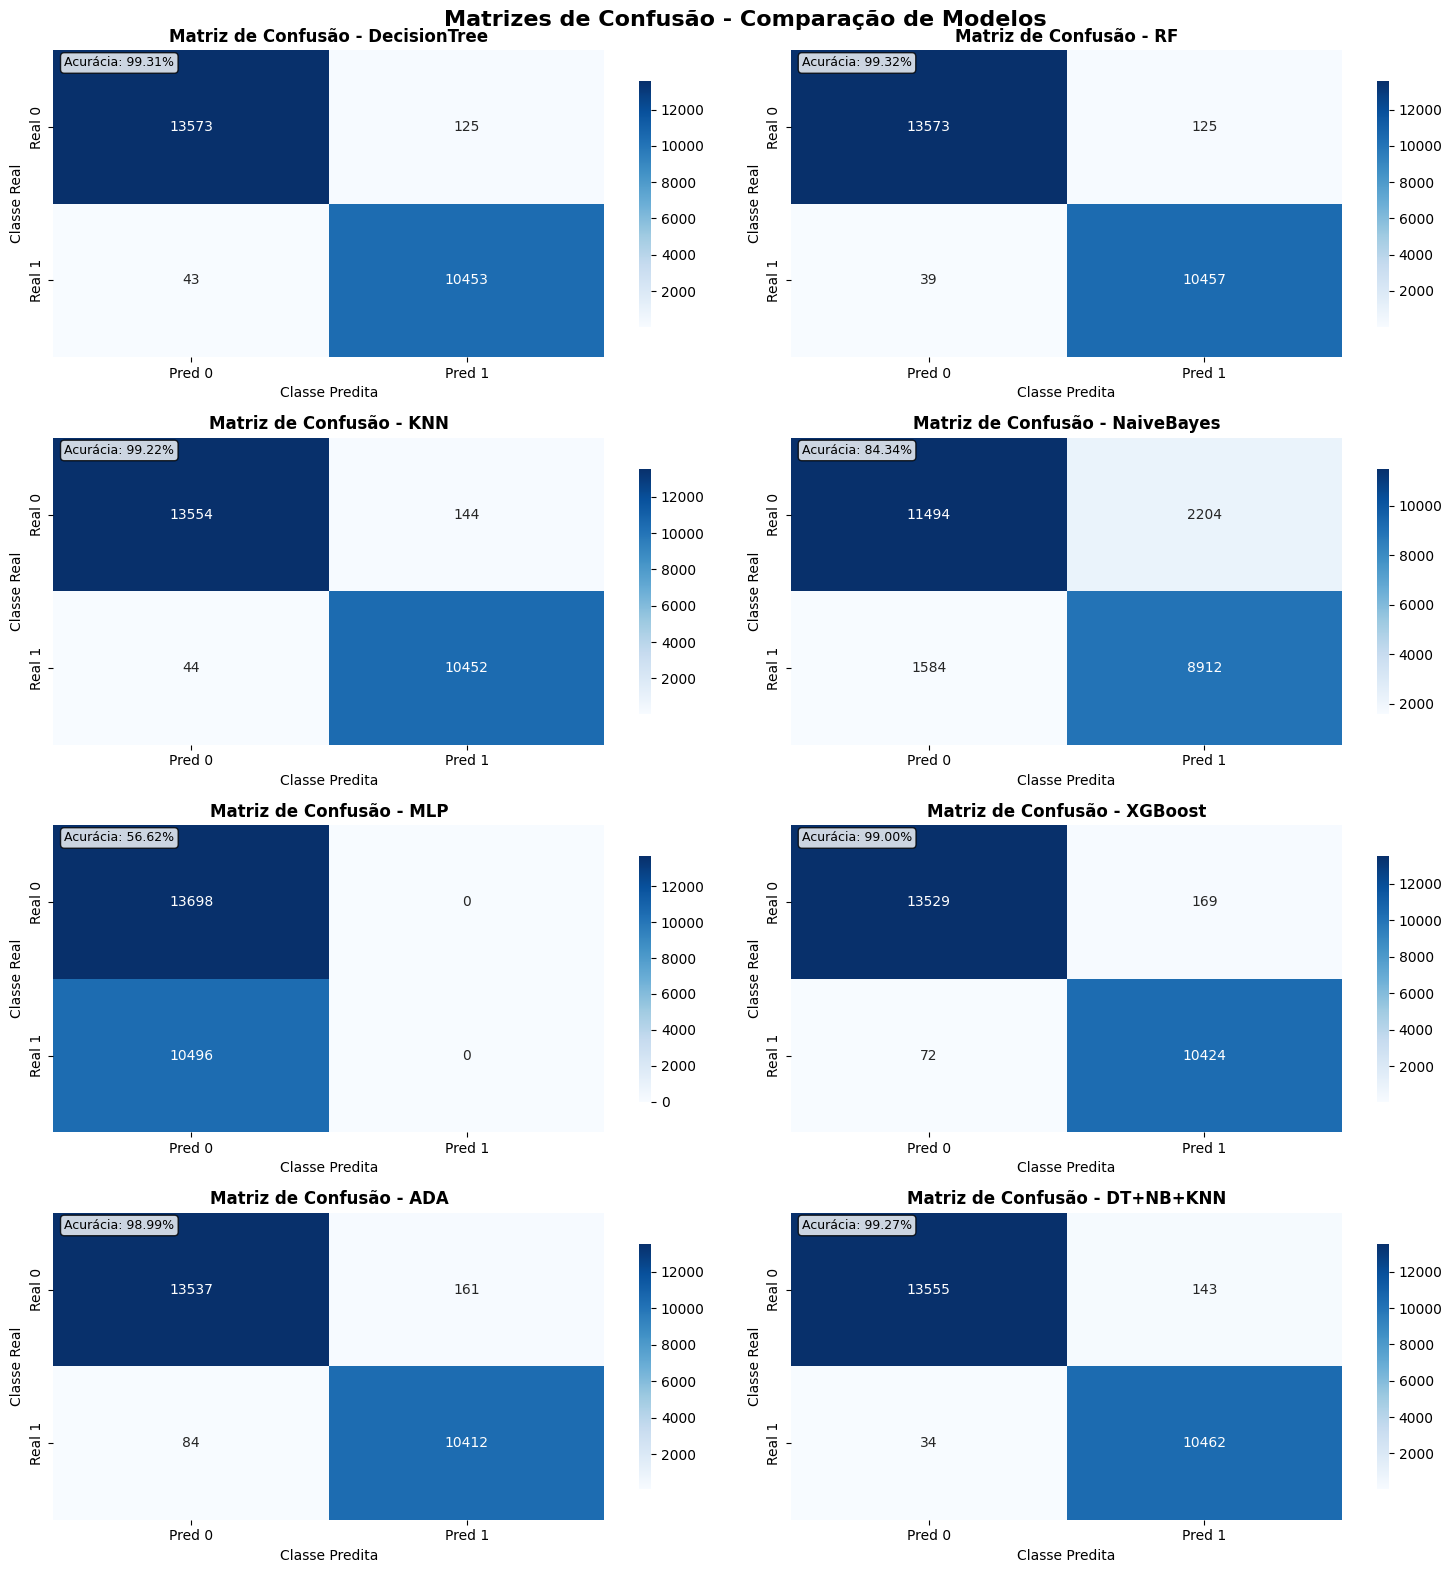


üéâ Matrizes de confus√£o geradas para 8 modelos!
üìä Layout: 4 linhas √ó 2 colunas

üìà RESUMO DAS ACUR√ÅCIAS:
 1. DecisionTree   :  99.31%
 2. RF             :  99.32%
 3. KNN            :  99.22%
 4. NaiveBayes     :  84.34%
 5. MLP            :  56.62%
 6. XGBoost        :  99.00%
 7. ADA            :  98.99%
 8. DT+NB+KNN      :  99.27%
 8. DT+NB+KNN      :  99.27%


In [61]:
# Matriz de confus√£o (apenas para classificadores)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("üéØ Gerando Matrizes de Confus√£o para todos os modelos...")

# Calcular o n√∫mero de linhas necess√°rias (2 colunas por linha)
n_models = len(methods)
n_rows = (n_models + 1) // 2  # Arredonda para cima

# Criar subplots com 2 colunas
fig3, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Garantir que axes seja sempre um array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_models == 1:
    axes = axes.reshape(-1, 1)

# Iterar pelos modelos e plotar matrizes de confus√£o
for i, (clf, title) in enumerate(zip(methods, titles)):
    # Calcular posi√ß√£o na grade (linha, coluna)
    row = i // 2
    col = i % 2
    
    print(f"üìä Processando modelo {i+1}/{n_models}: {title}")
    
    try:
        # Fazer predi√ß√µes
        y_predicted = clf.predict(X_test)
        
        # Calcular matriz de confus√£o
        cm = confusion_matrix(y_test, y_predicted)
        
        # Plotar usando seaborn heatmap
        df_cm = pd.DataFrame(cm, 
                           index=[f'Real {i}' for i in range(len(cm))],
                           columns=[f'Pred {i}' for i in range(len(cm))])
        
        sns.heatmap(df_cm, 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues',
                   ax=axes[row, col],
                   cbar_kws={'shrink': 0.8})
        
        axes[row, col].set_title(f'Matriz de Confus√£o - {title}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Classe Predita', fontsize=10)
        axes[row, col].set_ylabel('Classe Real', fontsize=10)
        
        # Calcular e exibir m√©tricas
        accuracy = (cm.diagonal().sum() / cm.sum()) * 100
        
        # Adicionar texto com acur√°cia
        axes[row, col].text(0.02, 0.98, f'Acur√°cia: {accuracy:.2f}%', 
                           transform=axes[row, col].transAxes,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=9)
        
        print(f"   ‚úÖ {title}: Acur√°cia = {accuracy:.2f}%")
        
    except Exception as e:
        print(f"   ‚ùå Erro ao processar {title}: {e}")
        
        # Plotar mensagem de erro
        axes[row, col].text(0.5, 0.5, f'Erro ao gerar\nmatriz para {title}', 
                           ha='center', va='center',
                           transform=axes[row, col].transAxes,
                           fontsize=12, color='red')
        axes[row, col].set_title(f'Erro - {title}', fontsize=12, color='red')

# Ocultar subplot extra se n√∫mero √≠mpar de modelos
if n_models % 2 == 1 and n_rows > 1:
    axes[-1, -1].set_visible(False)

plt.suptitle('Matrizes de Confus√£o - Compara√ß√£o de Modelos', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

print(f"\nüéâ Matrizes de confus√£o geradas para {n_models} modelos!")
print(f"üìä Layout: {n_rows} linhas √ó 2 colunas")

# Resumo das acur√°cias
print(f"\nüìà RESUMO DAS ACUR√ÅCIAS:")
print("=" * 50)
for i, (clf, title) in enumerate(zip(methods, titles)):
    try:
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        accuracy = (cm.diagonal().sum() / cm.sum()) * 100
        print(f"{i+1:2d}. {title:15s}: {accuracy:6.2f}%")
    except:
        print(f"{i+1:2d}. {title:15s}: ERROR")

C:\Users\leopi\AppData\Local\Temp\ipykernel_40912\1903457535.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('Dark2')


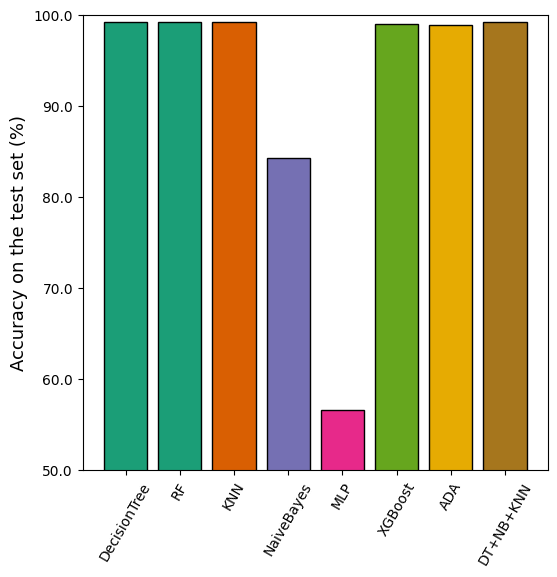

In [62]:
###############################################################################
# Plotting the results
# -----------------------
# Let's now evaluate the methods on the test set.
#
cmap = get_cmap('Dark2')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]
fig, ax = plt.subplots(figsize=(6, 6.5))
pct_formatter = FuncFormatter(lambda x, pos: '{:.1f}'.format(x * 100))
ax.bar(np.arange(len(methods)),
       scores,
       color=colors,
       tick_label=titles,
       edgecolor='k')

ax.set_ylim(0.50, 1.00)
ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
ax.yaxis.set_major_formatter(pct_formatter)
for tick in ax.get_xticklabels():
    tick.set_rotation(60)
plt.subplots_adjust(bottom=0.18)
plt.show()

üìà Gerando Curvas ROC/AUC para todos os modelos...
üîç Tipo de classifica√ß√£o detectado: Bin√°ria (2 classes)

üéØ Processando classifica√ß√£o bin√°ria...
üìä Processando DecisionTree...
   ‚úÖ DecisionTree: AUC = 0.9974
üìä Processando RF...
   ‚úÖ RF: AUC = 0.9984
üìä Processando KNN...
   ‚úÖ KNN: AUC = 0.9942
üìä Processando NaiveBayes...
   ‚úÖ NaiveBayes: AUC = 0.9228
üìä Processando MLP...
   ‚úÖ MLP: AUC = 0.5000
üìä Processando XGBoost...
   ‚úÖ XGBoost: AUC = 0.9990
üìä Processando ADA...
   ‚úÖ ADA: AUC = 0.9982   ‚úÖ ADA: AUC = 0.9982
üìä Processando DT+NB+KNN...
   ‚úÖ DT+NB+KNN: AUC = 0.9972

üìä Processando DT+NB+KNN...
   ‚úÖ DT+NB+KNN: AUC = 0.9972


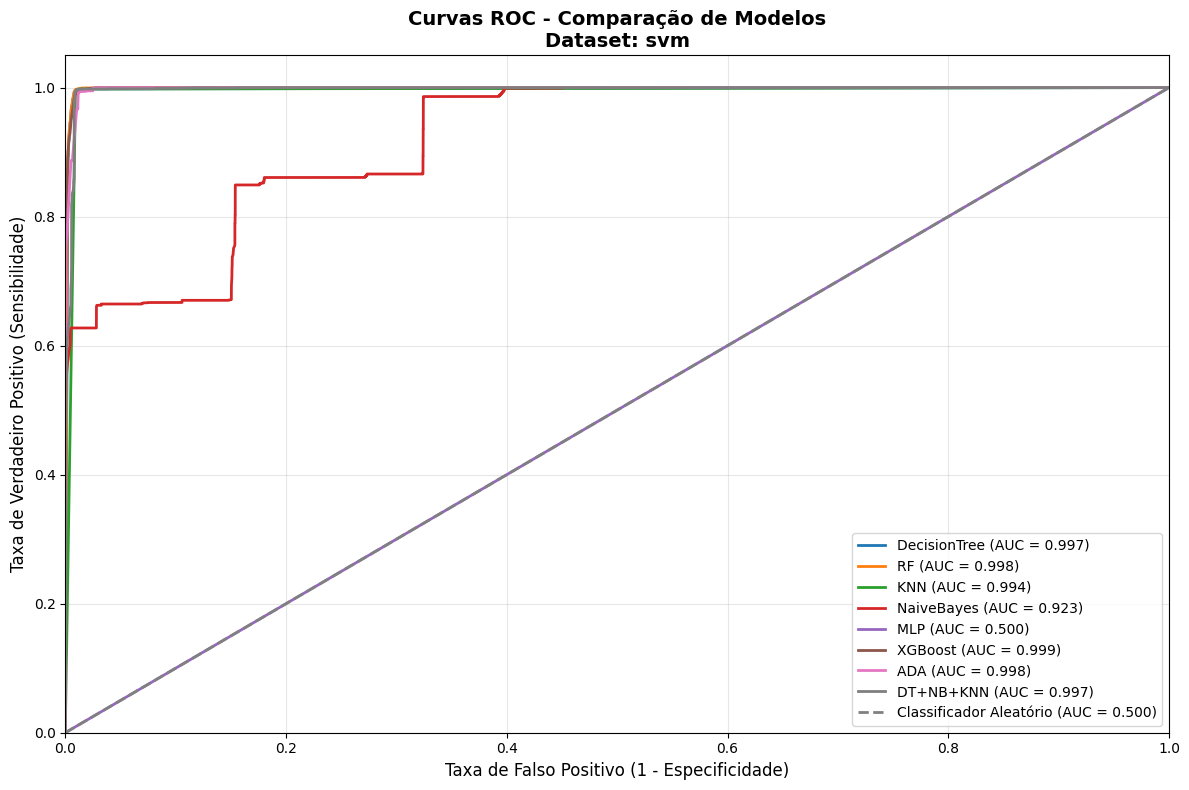


üìä Gerando gr√°fico de compara√ß√£o dos scores AUC...


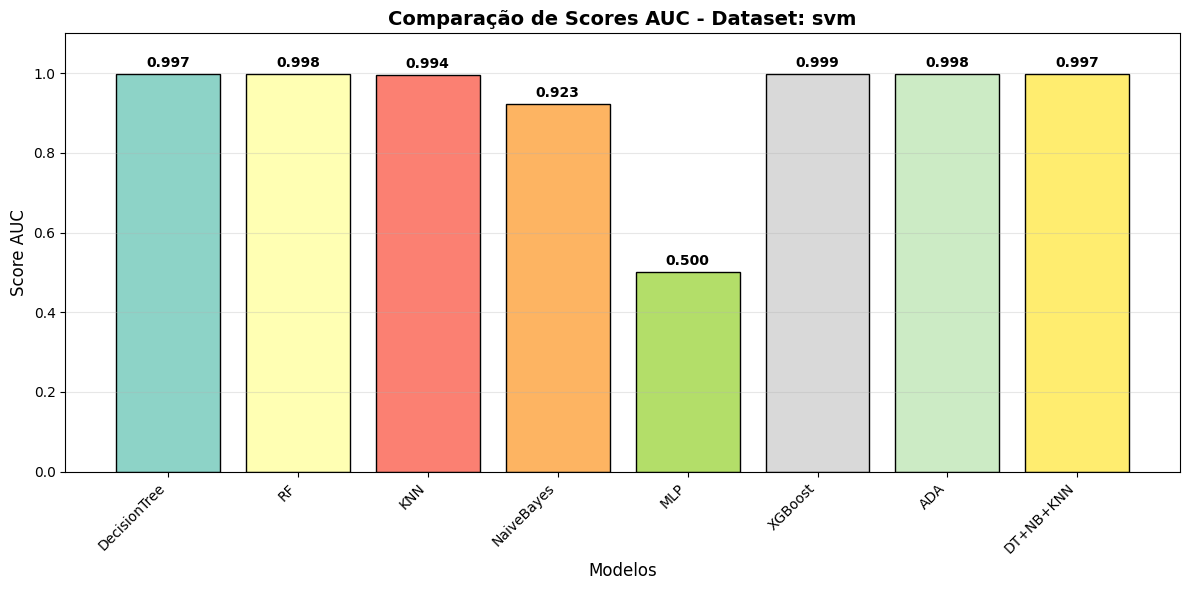


üèÜ RESUMO DOS SCORES AUC:
‚úÖ DecisionTree   : 0.9974
‚úÖ RF             : 0.9984
‚úÖ KNN            : 0.9942
‚úÖ NaiveBayes     : 0.9228
‚úÖ MLP            : 0.5000
‚úÖ XGBoost        : 0.9990
‚úÖ ADA            : 0.9982
‚úÖ DT+NB+KNN      : 0.9972

ü•á RANKING POR AUC:
----------------------------------------
ü•á XGBoost        : 0.9990
ü•à RF             : 0.9984
ü•â ADA            : 0.9982
 4. DecisionTree   : 0.9974
 5. DT+NB+KNN      : 0.9972
 6. KNN            : 0.9942
 7. NaiveBayes     : 0.9228
 8. MLP            : 0.5000

üìä ESTAT√çSTICAS AUC:
------------------------------
Melhor AUC: 0.9990 (XGBoost)
AUC M√©dio: 0.9259
Desvio Padr√£o: 0.1741

üí° DataFrame 'auc_df' dispon√≠vel para an√°lises adicionais.

üéâ An√°lise ROC/AUC completa para 8 modelos!


In [63]:
# Gera√ß√£o de Curvas ROC/AUC para todos os classificadores
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import cycle

print("üìà Gerando Curvas ROC/AUC para todos os modelos...")

# Verificar se √© classifica√ß√£o bin√°ria ou multiclasse
n_classes = len(np.unique(y_test))
print(f"üîç Tipo de classifica√ß√£o detectado: {'Bin√°ria' if n_classes == 2 else 'Multiclasse'} ({n_classes} classes)")

# Configurar cores para os gr√°ficos
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

# Lista para armazenar os valores AUC
auc_scores = []

if n_classes == 2:
    # CLASSIFICA√á√ÉO BIN√ÅRIA - ROC/AUC tradicional
    print("\nüéØ Processando classifica√ß√£o bin√°ria...")
    
    plt.figure(figsize=(12, 8))
    
    for clf, title, color in zip(methods, titles, colors):
        print(f"üìä Processando {title}...")
        
        try:
            # Obter probabilidades de predi√ß√£o (necess√°rio para ROC)
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf, "decision_function"):
                y_score = clf.decision_function(X_test)
            else:
                print(f"   ‚ö†Ô∏è {title}: Modelo n√£o suporta probabilidades - usando predi√ß√µes bin√°rias")
                y_score = clf.predict(X_test)
            
            # Calcular curva ROC
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            auc_scores.append(roc_auc)
            
            # Plotar curva ROC
            plt.plot(fpr, tpr, color=color, lw=2, 
                    label=f'{title} (AUC = {roc_auc:.3f})')
            
            print(f"   ‚úÖ {title}: AUC = {roc_auc:.4f}")
            
        except Exception as e:
            print(f"   ‚ùå Erro ao processar {title}: {e}")
            auc_scores.append(np.nan)
    
    # Adicionar linha diagonal (classificador aleat√≥rio)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
             label='Classificador Aleat√≥rio (AUC = 0.500)')
    
    # Configurar gr√°fico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo (1 - Especificidade)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiro Positivo (Sensibilidade)', fontsize=12)
    plt.title(f'Curvas ROC - Compara√ß√£o de Modelos\nDataset: {nome_dataset}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    # CLASSIFICA√á√ÉO MULTICLASSE - ROC/AUC One-vs-Rest
    print(f"\nüéØ Processando classifica√ß√£o multiclasse ({n_classes} classes)...")
    
    # Binarizar labels para One-vs-Rest
    lb = LabelBinarizer()
    y_test_bin = lb.fit_transform(y_test)
    
    # Se s√≥ h√° 2 classes, LabelBinarizer retorna 1D - converter para 2D
    if y_test_bin.shape[1] == 1:
        y_test_bin = np.hstack([1 - y_test_bin, y_test_bin])
    
    # Calcular n√∫mero de subplots necess√°rios
    n_models = len(methods)
    n_cols = 3  # 3 colunas por linha
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    # Garantir que axes seja sempre um array 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, (clf, title) in enumerate(zip(methods, titles)):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_models > 1 else axes
        
        print(f"üìä Processando {title}...")
        
        try:
            # Obter probabilidades de predi√ß√£o
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test)
            elif hasattr(clf, "decision_function"):
                y_score = clf.decision_function(X_test)
                # Normalizar scores para [0,1] se necess√°rio
                if y_score.min() < 0:
                    y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
            else:
                print(f"   ‚ö†Ô∏è {title}: Modelo n√£o suporta probabilidades")
                continue
            
            # Calcular ROC para cada classe (One-vs-Rest)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i in range(n_classes):
                if y_score.shape[1] > i:  # Verificar se a classe existe
                    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Plotar ROC para cada classe
            class_colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
            for i, color in zip(range(n_classes), class_colors):
                if i in roc_auc:
                    ax.plot(fpr[i], tpr[i], color=color, lw=2,
                           label=f'Classe {i} (AUC = {roc_auc[i]:.3f})')
            
            # Calcular AUC m√©dio
            mean_auc = np.mean(list(roc_auc.values())) if roc_auc else 0
            auc_scores.append(mean_auc)
            
            # Linha diagonal
            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            
            # Configurar subplot
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Taxa de Falso Positivo')
            ax.set_ylabel('Taxa de Verdadeiro Positivo')
            ax.set_title(f'{title}\n(AUC M√©dio = {mean_auc:.3f})', fontweight='bold')
            ax.legend(loc="lower right", fontsize=8)
            ax.grid(True, alpha=0.3)
            
            print(f"   ‚úÖ {title}: AUC M√©dio = {mean_auc:.4f}")
            
        except Exception as e:
            print(f"   ‚ùå Erro ao processar {title}: {e}")
            auc_scores.append(np.nan)
            
            # Plotar mensagem de erro
            ax.text(0.5, 0.5, f'Erro ao gerar\nROC para {title}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, color='red')
            ax.set_title(f'Erro - {title}', color='red')
    
    # Ocultar subplots extras
    for idx in range(n_models, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        if n_models > 1:
            axes[row, col].set_visible(False)
    
    plt.suptitle(f'Curvas ROC (One-vs-Rest) - Dataset: {nome_dataset}', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Gr√°fico de barras com scores AUC
print(f"\nüìä Gerando gr√°fico de compara√ß√£o dos scores AUC...")

plt.figure(figsize=(12, 6))
valid_indices = [i for i, score in enumerate(auc_scores) if not np.isnan(score)]
valid_scores = [auc_scores[i] for i in valid_indices]
valid_titles = [titles[i] for i in valid_indices]

if valid_scores:
    colors_bar = plt.cm.Set3(np.linspace(0, 1, len(valid_scores)))
    bars = plt.bar(range(len(valid_scores)), valid_scores, color=colors_bar, 
                   edgecolor='black', linewidth=1)
    
    # Adicionar valores no topo das barras
    for i, (bar, score) in enumerate(zip(bars, valid_scores)):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.xlabel('Modelos', fontsize=12)
    plt.ylabel('Score AUC', fontsize=12)
    plt.title(f'Compara√ß√£o de Scores AUC - Dataset: {nome_dataset}', 
              fontsize=14, fontweight='bold')
    plt.xticks(range(len(valid_scores)), valid_titles, rotation=45, ha='right')
    plt.ylim(0, 1.1)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Resumo dos resultados
print(f"\nüèÜ RESUMO DOS SCORES AUC:")
print("=" * 60)
auc_data = []
for title, score in zip(titles, auc_scores):
    if not np.isnan(score):
        auc_data.append({'modelo': title, 'auc_score': score})
        print(f"‚úÖ {title:15s}: {score:.4f}")
    else:
        print(f"‚ùå {title:15s}: ERROR")

if auc_data:
    # Criar DataFrame com scores AUC
    auc_df = pd.DataFrame(auc_data)
    auc_df_sorted = auc_df.sort_values('auc_score', ascending=False).reset_index(drop=True)
    
    print(f"\nü•á RANKING POR AUC:")
    print("-" * 40)
    for i, row in auc_df_sorted.iterrows():
        medal = "ü•á" if i == 0 else "ü•à" if i == 1 else "ü•â" if i == 2 else f"{i+1:2d}."
        print(f"{medal} {row['modelo']:15s}: {row['auc_score']:.4f}")
    
    print(f"\nüìä ESTAT√çSTICAS AUC:")
    print("-" * 30)
    print(f"Melhor AUC: {auc_df['auc_score'].max():.4f} ({auc_df.loc[auc_df['auc_score'].idxmax(), 'modelo']})")
    print(f"AUC M√©dio: {auc_df['auc_score'].mean():.4f}")
    print(f"Desvio Padr√£o: {auc_df['auc_score'].std():.4f}")
    
    # Disponibilizar DataFrame para uso posterior
    globals()['auc_df'] = auc_df
    print(f"\nüí° DataFrame 'auc_df' dispon√≠vel para an√°lises adicionais.")

print(f"\nüéâ An√°lise ROC/AUC completa para {len([s for s in auc_scores if not np.isnan(s)])} modelos!")